# **Urban land cover in the City of Boulder**

Land cover is a significant driver of temperatures in the urban environment and differences in the quantity of urban greenspace and low albedo (darker) surfaces can be a driver of inequalities in human thermal comfort across cities [1]. In this notebook, I conduct a basic analysis of land cover within the limits of the City of Boulder, Colorado, using the k-means clustering algorithim, to identify the city's urban land cover types. While this analysis should not be taken as conclusive evidence for the distribution of greenspace, it can provide an initial look into the land cover types that are present across the city.

The City of Boulder, Colorado is a picturesque college town in the western United States at the foothills of the Rocky Mountains. The city is known for its long history of valuing environmental conservation and outdoor recreation which has resulted in a network of land preserves around the city as well as urban parks within the city [2]. The city also has an extensive urban forest which is denser in some areas of the city than others [3]. In recent decades, Boulder has experienced significant urban development, especially in its downtown core and on the edges of the City [2]. This history has resulted in a wide range of urban building density across Boulder, making the city an interesting place to understand how spectral characteristics can be used to understand land cover.

In [2]:
import cartopy.crs as ccrs
import earthaccess
import earthpy as et
import geopandas as gpd
import geoviews as gv
import hvplot.xarray

import hvplot.pandas
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import hvplot.pandas
from shapely.geometry import Polygon
import xarray as xr
import rasterio
import requests
import rioxarray as rxr
import rioxarray.merge as rxr_merge
import io
from sklearn.cluster import KMeans
import sklearn
import warnings
import zarr

os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"


warnings.filterwarnings('ignore')

import holoviews as hv

In [3]:
def cached(key, override=False):
    """"""
    def compute_and_cache_decorator(compute_function):
        """"""
        def compute_and_cache(*args, **kwargs):
            """Perform a computation and cache, or load cached result"""
            filename = os.path.join(et.io.HOME, et.io.DATA_NAME, 'jars', f'{key}.pickle')
            
            # Check if the cache exists already or override caching
            if not os.path.exists(filename) or override:
                # Make jars directory if needed
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                
                # Run the compute function as the user did
                result = compute_function(*args, **kwargs)
                
                # Pickle the object
                with open(filename, 'wb') as file:
                    pickle.dump(result, file)
            else:
                # Unpickle the object
                with open(filename, 'rb') as file:
                    result = pickle.load(file)
                    
            return result
        
        return compute_and_cache
    
    return compute_and_cache_decorator

## Site boundary

In [4]:
# Set directories
project_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'boulder-land-cover')
data_dir = os.path.join(project_dir, 'data')

for a_dir in [project_dir, data_dir]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

Data is already downloaded.


<Axes: >

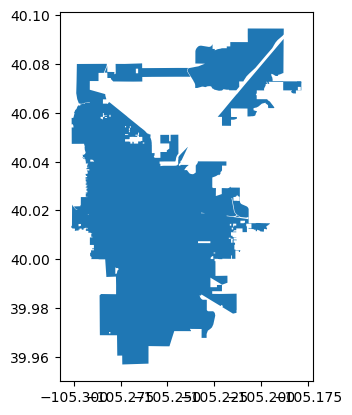

In [5]:
# Download City of Boulder boundary

boundary_url = ("https://gis.bouldercolorado.gov/ags_svr1/rest/services/plan/CityLimits/MapServer/0/query?outFields=*&where=1%3D1&f=geojson")

boundary_path = os.path.join(data_dir, 'city_boundary.geojson')

if os.path.exists(boundary_path):
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data is already downloaded.")
else:
    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=boundary_url, headers={'User-Agent': user_agent})

    # Read GeoJSON data into a GeoDataFrame
    boundary_geojson_data = r.json()

    # Cache
    boundary_gdf = (gpd.GeoDataFrame
                    .from_features(boundary_geojson_data['features'])
                    .to_file(boundary_path, driver="GeoJSON")
                    )
    
    # Read
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data downloaded and loaded.")

boundary_gdf.plot()

# See what the bounds are
# boundary_gdf.total_bounds

In [6]:
# Search for data
earthaccess.login(persist=True)

results = earthaccess.search_data(
    short_name="HLSL30",
    cloud_hosted=True,
    bounding_box=tuple(boundary_gdf.total_bounds),
    temporal=("May 2023", "August 2023"),
)

Granules found: 23


In [7]:
# Subset the data
results_subset = results[1:15]

In [8]:
# Compile information about each granule
# @cached('results_gdf')
def compile_info(results_list):
    """
    For a list of search results from earthaccess, compiles a GeoDataFrame of granules with URLs and relevant information.

    Parameters
    ----------
    results_list : list
        A list of EarthData results generated using the earthaccess library.

    Returns
    ----------
    results_gdf : GeoDataFrame
        Contains URLs for each granule and relevant information.

    """

    columns = ['granule_id', 'datetime', 'geometry', 'url', 'tile_id',
               'band']

    # To store info for each result
    results_df = pd.DataFrame(columns=columns)

    for item in results_list:

        print(item)
        # Retrieve info
        umm = item['umm']

        granule_id = umm['GranuleUR']

        datetime = umm['TemporalExtent']['RangeDateTime']['BeginningDateTime']

        # Retrieve geometries
        geometry_info = umm['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']

        for part in geometry_info:
            # Access the 'Boundary' dictionary
            boundary_dict = part['Boundary']
            # Access the list of points within the 'Boundary' dictionary
            points_list = boundary_dict['Points']

        xy_list = [(coord['Longitude'], coord['Latitude']) for coord in points_list]
        geometry = Polygon(xy_list)
        
        # Open granule files
        granule = earthaccess.open([item])

        # Get info for each band
        for info in granule:

            url = info.url
            split_position = 108

            tile = url[split_position:]
            # print(tile)

            tile_id_split = 35
            tile_id = tile[:tile_id_split]

            band_split = -3
            band_ext = tile[tile_id_split:]
            band_period = band_ext[:band_split]

            band = band_period[:-1]

            # Create single gdf row
            band_info = {'granule_id': [granule_id], 'datetime': [datetime], 
                    'geometry': [geometry], 'url': [url], 'tile_id': [tile_id],
                     'band': [band]}
            
            band_df = pd.DataFrame(band_info)
            
            # Add to df
            results_df = pd.concat([results_df, band_df], ignore_index=True)

    results_gdf = gpd.GeoDataFrame(results_df, geometry='geometry')

    return results_gdf
    
results_info = compile_info(results_list = results_subset)

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.92294205, 'Latitude': 39.6615814}, {'Longitude': -104.88603695, 'Latitude': 39.77291762}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-08T17:42:50.705Z', 'EndingDateTime': '2023-05-08T17:43:14.592Z'}}
Size(MB): 208.79395866394043
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023128T174250.v2.0/HLS.L30.T13TDE.2023128T174250.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023128T174250.v2.0/HLS.L30.T

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.5982624, 'Latitude': 39.66006613}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.3043374, 'Latitude': 40.65045548}, {'Longitude': -105.5982624, 'Latitude': 39.66006613}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-09T17:36:57.025Z', 'EndingDateTime': '2023-05-09T17:37:20.916Z'}}
Size(MB): 87.9737663269043
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023129T173657.v2.0/HLS.L30.T13TDE.2023129T173657.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023129T173657.v2.0/HLS.L30.T13TDE.2023129T173657.v2.0.SAA.tif', 'https://data.lpdaac

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.91419872, 'Latitude': 39.66157527}, {'Longitude': -104.88608105, 'Latitude': 39.74615744}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-16T17:43:04.644Z', 'EndingDateTime': '2023-05-16T17:43:28.522Z'}}
Size(MB): 206.25780391693115
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023136T174304.v2.0/HLS.L30.T13TDE.2023136T174304.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023136T174304.v2.0/HLS.L30.

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.5681875, 'Latitude': 39.66021716}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.27204702, 'Latitude': 40.65053606}, {'Longitude': -105.5681875, 'Latitude': 39.66021716}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-17T17:36:33.039Z', 'EndingDateTime': '2023-05-17T17:36:56.934Z'}}
Size(MB): 88.95021057128906
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023137T173633.v2.0/HLS.L30.T13TDE.2023137T173633.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023137T173633.v2.0/HLS.L30.T13TDE.2023137T173633.v2.0.B02.tif', 'https://data.lpda

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-24T17:42:47.017Z', 'EndingDateTime': '2023-05-24T17:43:10.913Z'}}
Size(MB): 196.6626272201538
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023144T174247.v2.0/HLS.L30.T13TDE.2023144T174247.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023144T174247.v2.0/HLS.L30.T13TDE.2023144T174247.v2.0.SAA.tif', 'https://data.lpdaa

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.59721328, 'Latitude': 39.66007153}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.30327289, 'Latitude': 40.65045828}, {'Longitude': -105.59721328, 'Latitude': 39.66007153}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-05-25T17:36:46.460Z', 'EndingDateTime': '2023-05-25T17:37:10.351Z'}}
Size(MB): 86.09668350219727
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023145T173646.v2.0/HLS.L30.T13TDE.2023145T173646.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023145T173646.v2.0/HLS.L30.T13TDE.2023145T173646.v2.0.B01.tif', 'https://data.lp

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.92643938, 'Latitude': 39.66158366}, {'Longitude': -104.88601911, 'Latitude': 39.78372977}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-01T17:42:56.999Z', 'EndingDateTime': '2023-06-01T17:43:20.885Z'}}
Size(MB): 207.11719417572021
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023152T174256.v2.0/HLS.L30.T13TDE.2023152T174256.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023152T174256.v2.0/HLS.L30.

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.54790431, 'Latitude': 39.66031461}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.25217595, 'Latitude': 40.65058117}, {'Longitude': -105.54790431, 'Latitude': 39.66031461}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-02T17:36:37.078Z', 'EndingDateTime': '2023-06-02T17:37:00.973Z'}}
Size(MB): 86.47270965576172
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023153T173637.v2.0/HLS.L30.T13TDE.2023153T173637.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023153T173637.v2.0/HLS.L30.T13TDE.2023153T173637.v2.0.B02.tif', 'https://data.lp

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-09T17:42:53.790Z', 'EndingDateTime': '2023-06-09T17:43:17.681Z'}}
Size(MB): 203.6312551498413
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023160T174253.v2.0/HLS.L30.T13TDE.2023160T174253.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023160T174253.v2.0/HLS.L30.T13TDE.2023160T174253.v2.0.B03.tif', 'https://data.lpdaa

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.62064357, 'Latitude': 39.65994869}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.32633737, 'Latitude': 40.6503954}, {'Longitude': -105.62064357, 'Latitude': 39.65994869}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-10T17:36:41.386Z', 'EndingDateTime': '2023-06-10T17:37:05.273Z'}}
Size(MB): 94.80309009552002
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023161T173641.v2.0/HLS.L30.T13TDE.2023161T173641.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023161T173641.v2.0/HLS.L30.T13TDE.2023161T173641.v2.0.VZA.tif', 'https://data.lpd

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-17T17:42:48.052Z', 'EndingDateTime': '2023-06-17T17:43:11.943Z'}}
Size(MB): 200.67501068115234
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023168T174248.v2.0/HLS.L30.T13TDE.2023168T174248.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023168T174248.v2.0/HLS.L30.T13TDE.2023168T174248.v2.0.VAA.tif', 'https://data.lpda

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.55245055, 'Latitude': 39.66029308}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.25678888, 'Latitude': 40.650571}, {'Longitude': -105.55245055, 'Latitude': 39.66029308}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-18T17:36:46.079Z', 'EndingDateTime': '2023-06-18T17:37:09.966Z'}}
Size(MB): 82.86638641357422
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023169T173646.v2.0/HLS.L30.T13TDE.2023169T173646.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023169T173646.v2.0/HLS.L30.T13TDE.2023169T173646.v2.0.B06.tif', 'https://data.lpda

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.1661317, 'Latitude': 39.65575257}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -106.18317261, 'Latitude': 40.6447948}, {'Longitude': -106.1661317, 'Latitude': 39.65575257}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-25T17:43:00.237Z', 'EndingDateTime': '2023-06-25T17:43:24.128Z'}}
Size(MB): 189.01641464233398
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023176T174300.v2.0/HLS.L30.T13TDE.2023176T174300.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023176T174300.v2.0/HLS.L30.T13TDE.2023176T174300.v2.0.B09.tif', 'https://data.lpda

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.55874534, 'Latitude': 39.66026296}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.26317601, 'Latitude': 40.65055662}, {'Longitude': -105.55874534, 'Latitude': 39.66026296}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-06-26T17:36:38.725Z', 'EndingDateTime': '2023-06-26T17:37:02.616Z'}}
Size(MB): 79.44844913482666
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023177T173638.v2.0/HLS.L30.T13TDE.2023177T173638.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2023177T173638.v2.0/HLS.L30.T13TDE.2023177T173638.v2.0.B04.tif', 'https://data.lp

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
# Select the first three dates

# results_sorted = results_info.sort_values(by=['datetime', 'band']).reset_index()
# results_subset = results_sorted[1:14]
# results_subset


results_sorted = results_info.sort_values(by=['datetime', 'band']).reset_index()
selected_dates = results_sorted['datetime'].unique()[:3]
results_subset = results_sorted[results_sorted['datetime'].isin(selected_dates)]

results_subset.head()

,index,granule_id,datetime,geometry,url,tile_id,band
0,10,HLS.L30.T13TDE.2023128T174250.v2.0,2023-05-08T17:42:50.705Z,"POLYGON ((-106.16613 39.65575, -104.92294 39.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,HLS.L30.T13TDE.2023128T174250.v2.0.,B01
1,11,HLS.L30.T13TDE.2023128T174250.v2.0,2023-05-08T17:42:50.705Z,"POLYGON ((-106.16613 39.65575, -104.92294 39.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,HLS.L30.T13TDE.2023128T174250.v2.0.,B02
2,5,HLS.L30.T13TDE.2023128T174250.v2.0,2023-05-08T17:42:50.705Z,"POLYGON ((-106.16613 39.65575, -104.92294 39.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,HLS.L30.T13TDE.2023128T174250.v2.0.,B03
3,3,HLS.L30.T13TDE.2023128T174250.v2.0,2023-05-08T17:42:50.705Z,"POLYGON ((-106.16613 39.65575, -104.92294 39.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,HLS.L30.T13TDE.2023128T174250.v2.0.,B04
4,4,HLS.L30.T13TDE.2023128T174250.v2.0,2023-05-08T17:42:50.705Z,"POLYGON ((-106.16613 39.65575, -104.92294 39.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,HLS.L30.T13TDE.2023128T174250.v2.0.,B05


In [10]:
# # Test if the granule matches what we want
# test_granule_map = results_subset.hvplot(geo=True, tiles='EsriImagery', fill_alpha=0, line_color = "white")
# test_granule_map

In [11]:
# @cached('boulder_land_cover_raster_info')
def download_data(results_compiled):
    """
    For a GeoDataFrame containing granule URLs and relevant information, 
    downloads the data using the earthpy library to earthpy home 
    directory in the local machine. The directory must be set
    using earthpy prior to running this function.

    Parameters
    ----------
    results_compiled : GeoDataFrame
        Must contain granule URLs.
    
    Returns
    -------
    raster_info : GeoDataFrame
        Containing file paths for the data files which are downloaded to the local machine.
    """

    raster_info = results_compiled

    for index, image in results_compiled.iterrows():

        url = image['url']
        # print(url)

        # If using earthaccess directly (NOT implemented yet)
        # image_opened = earthaccess.download(url)
        # rxr.open_rasterio(url)
        # Clip box on download if downloading using earthaccess
        # Will need to use cache decorator (if caching manually can use netCDF)
        # earthaccess.open(url)
        # raster = rxr.open_rasterio(image.url)

        raster = et.data.get_data(url = url)
        # print(raster)

        raster_info.loc[index, 'file_path'] = raster
    
    return raster_info

raster_gdf = download_data(results_compiled = results_subset)

In [12]:
# See what dates have been downloaded
# print(raster_gdf['datetime'].unique())

# dates_grouped = raster_gdf.groupby('datetime')

# for datetime, group_data in dates_grouped:
#     band = group_data['band']
#     print(band)

In [13]:
def open_image(path, scale_factor=1):
    """
    Opens image, applies scale factor, reprojects to the same CRS as the
    project boundary, and crops image to project boundary.

    Parameters
    ----------
    path : string

    Returns
    -------
    raster_clipped_da : xarray.DataArray
        A data array for the image after scaling, reprojecting, and cropping.

    """
            
    raster_da = (rxr.open_rasterio(path, masked = True).squeeze())
            
    # Divide by scale factor
    raster_scaled_da = (raster_da * scale_factor)

    # Reproject
    project_boundary_gdf = boundary_gdf.to_crs(raster_scaled_da.rio.crs)

    minx, miny, maxx, maxy = project_boundary_gdf.total_bounds

    # Crop to watershed boundary
    raster_clipped_da = raster_scaled_da.rio.clip_box(minx, miny, maxx, maxy)

    return(raster_clipped_da)

In [14]:
def compute_cloud_mask(da, mask_bits=[
    # 7, 
    # 6, 
    5, 
    3, 
    2, 
    1]):
    """
    Computes cloud mask by removing aerosols, water, snow/ice, cloud shadow,
     pixels adjacent to cloud/shadow, and cloud. See details of the 
     Quality Assessment layer at https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf.

     Parameters
     ----------
     da : xarray.DataArray

     Returns
     -------
     mask : array
    """

    # Unpack bits
    bits = np.unpackbits(da.astype(np.uint8), bitorder='little').reshape(da.shape + (-1,))

    # Select required bits
    mask = np.prod(bits[..., mask_bits]==0, axis=-1)

    return(mask)

In [15]:
all_rasters_list = []

# Process all the rasters
for date, date_data in raster_gdf.groupby('datetime'):

    # print(f"processing date: {date}")

    rasters_for_each_date_list = []

    # Create quality mask
    Fmask_df = date_data[date_data['band'] == 'Fmask']

    # Test if the Fmask was properly selected
    # print(Fmask_df)

    Fmask_rasters = []

    for index, image in Fmask_df.iterrows():

        path = Fmask_df.loc[index, 'file_path']
        Fmask_da = open_image(path)

        Fmask_rasters.append(Fmask_da)  

    merged_Fmask_da = rxr_merge.merge_arrays(Fmask_rasters, crs=32616)

    merged_Fmask_da = (merged_Fmask_da
                    .assign_coords(date=date)
                    .expand_dims({'date': [date]})
                    )
    
    # Test if the cloud mask worked
    # display(merged_Fmask_da)
    # merged_Fmask_da.where(merged_Fmask_da <= 1).plot()
    # plt.show()

    quality_mask = compute_cloud_mask(merged_Fmask_da)
    # display(quality_mask)

    # See if the quality mask was computed correctly
    # qmask_da = xr.DataArray(quality_mask)
    # qmask_da.plot()
    # plt.show()

    # Open all bands for the date
    for band, band_data in date_data.groupby('band'):

        if band not in ['B10', 'B11', 'Fmask', 'SZA', 'SAA', 'VZA', 'VAA']:

            # print(f"processing band: {band}")

            rasters_for_band = []
            
            # Download each image
            for index, image in band_data.iterrows():

                path = date_data.loc[index, 'file_path']

                try:
                    image_da = open_image(path, scale_factor=0.0001)

                except rasterio.errors.RasterioIOError as e:
                    print(f"Error reading file at path: {path}")
                    print(e)
                    continue

                rasters_for_band.append(image_da)

            # Merge rasters (granules) for each date
            try:
                merged_rasters = rxr_merge.merge_arrays(rasters_for_band, crs=32616)
            except:
                print("Error in merging. Moving on...")
                continue

            merged_rasters = (merged_rasters
                            .assign_coords(band=band)
                            .expand_dims({'band': [band]})
                            ) 
            
            rasters_for_each_date_list.append(merged_rasters)
        
    rasters_for_each_date_da = xr.concat(rasters_for_each_date_list, dim='band')

    # Mask out the clouds, aerosols, etc.
    masked_data = (rasters_for_each_date_da
                   .where(quality_mask)
    )

    # See if the clouds were masked out
    # masked_data.where(masked_data <= 1).sel(band='B01').plot()
    # plt.show()

    if len(all_rasters_list) > 0:
        first_raster = all_rasters_list[0] 
        masked_data = masked_data.rio.reproject_match(first_raster)


    masked_data = (masked_data
                   .assign_coords(date=date)
                   .expand_dims({'date': [date]})
                #    .where(masked_data <= 1)
                    )
    
    
    all_rasters_list.append(masked_data)
        
    # print(f"finished processing date: {date}")
    # print("\n")

In [16]:
# Combine all dates
all_rasters_da = xr.concat(all_rasters_list, dim='date')

In [17]:
# Test plot for the range of values
# all_rasters_da.plot.hist()

In [18]:
mean_data_da = all_rasters_da.mean(dim='date')

# Test whether the cloud mask worked
# bands = ['B01',
#         'B02', 
#         'B03', 
#         'B04', 
#         'B05', 
#         'B06', 
#         'B07', 
#         'B09']

# for band in bands: 
#     mean_data_da.sel(band=band).plot()
#     plt.show()

In [19]:
# View the QA layers
# raster_gdf_filtered = raster_gdf.query("band == 'Fmask'")

# for index, row in raster_gdf_filtered.iterrows():
#     path = row['file_path']
#     Fmask_image = open_image(path)

#     mask = compute_cloud_mask(Fmask_image)
#     plt.imshow(mask)
    

## Classifying land cover

In [20]:
# Crop the data to only the city limit, as we are only interested in distinguishing urban land covers

# Make sure CRSs match
mean_data_coords_da = mean_data_da.rio.reproject("EPSG:3857")

bounds = mean_data_coords_da.rio.transform_bounds("EPSG:3857")
boundary_coords_gdf = boundary_gdf.to_crs("3857")

print(boundary_coords_gdf.geometry)
print(boundary_coords_gdf.crs)

mean_data_cropped_da = mean_data_coords_da.rio.clip(boundary_coords_gdf.geometry)

mean_data_cleaned_da = mean_data_cropped_da.where(mean_data_cropped_da <= 0.5, other=0)

0    POLYGON ((-11711572.939 4876932.599, -11711572...
1    POLYGON ((-11708439.484 4875994.564, -11708401...
2    POLYGON ((-11712065.950 4868450.240, -11712077...
3    POLYGON ((-11717878.355 4877603.689, -11718254...
4    POLYGON ((-11713422.201 4864280.703, -11713437...
Name: geometry, dtype: geometry
EPSG:3857


In [21]:
# Want each band to be a column, each pixel and date to be in the index

mean_data_df = (mean_data_cleaned_da
                .sel(band=['B01',
                           'B02', 
                           'B03', 
                           'B04', 
                           'B05', 
                           'B06', 
                           'B07', 
                           'B09'])
                .unstack()
                .to_dataframe(name='value')
                .dropna()
                )

# Test
# mean_data_df['value'].hist()
# mean_data_df.head()

Data to be used in the clustering algorithm.

In [22]:
reflectance_df = (mean_data_df
                .pivot_table(index=['x', 'y'],
                             columns='band',
                             values='value'
                             )
                )
reflectance_df = reflectance_df.loc[(reflectance_df.sum(axis=1) != 0)]
reflectance_df.head()

band                             B01      B02       B03       B04       B05  \
x             y                                                               
-1.172210e+07 4.867834e+06  0.043300  0.05050  0.080800  0.082850  0.196900   
-1.172206e+07 4.867834e+06  0.045550  0.05060  0.070650  0.070000  0.177650   
              4.867872e+06  0.052450  0.05970  0.088300  0.092850  0.235300   
              4.867910e+06  0.040750  0.04985  0.085150  0.087650  0.262300   
              4.872819e+06  0.049933  0.06220  0.089633  0.100333  0.217967   

band                             B06       B07       B09  
x             y                                           
-1.172210e+07 4.867834e+06  0.150700  0.103700  0.001450  
-1.172206e+07 4.867834e+06  0.149550  0.104100  0.001500  
              4.867872e+06  0.211050  0.150550  0.001650  
              4.867910e+06  0.219000  0.148150  0.001900  
              4.872819e+06  0.221667  0.159433  0.002267

In this analysis, I used the k-means clustering algorithm to classify pixels into clusters inferred to be related to the land cover, based on the reflectance values of the pixel in multiple bands. This method relies on the analyst to specify the number of clusters that the data should be classified into. It is important to note that this algorithm simply classifies the pixels into groups based on similarity in spectral characteristics and therefore does not necessarily reflect the actual land cover. Additionally, the k-means method is a non-deterministic algorithm, which means that each time it is run, it will give a slightly different result.

Cluster labels after the algorithm is applied.

In [23]:
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init='auto')
kmeans.fit(
    reflectance_df
    [['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09']]
    )
 
reflectance_df['k_means_labels'] = kmeans.labels_
reflectance_df.head()

band                             B01      B02       B03       B04       B05  \
x             y                                                               
-1.172210e+07 4.867834e+06  0.043300  0.05050  0.080800  0.082850  0.196900   
-1.172206e+07 4.867834e+06  0.045550  0.05060  0.070650  0.070000  0.177650   
              4.867872e+06  0.052450  0.05970  0.088300  0.092850  0.235300   
              4.867910e+06  0.040750  0.04985  0.085150  0.087650  0.262300   
              4.872819e+06  0.049933  0.06220  0.089633  0.100333  0.217967   

band                             B06       B07       B09  k_means_labels  
x             y                                                           
-1.172210e+07 4.867834e+06  0.150700  0.103700  0.001450               4  
-1.172206e+07 4.867834e+06  0.149550  0.104100  0.001500               4  
              4.867872e+06  0.211050  0.150550  0.001650               4  
              4.867910e+06  0.219000  0.148150  0.001900               0  
              4.872819e+06  0.221667  0.159433  0.002267               4

## Visualizing land cover across the city

In [27]:
# Plot true color image next to clusters.

# Project boundary
boundary_map = boundary_gdf.hvplot(geo=True, tiles='EsriImagery', fill_alpha=0, line_color="white")

# Adjust true color image
rgb = mean_data_da.sel(band=['B04', 'B03', 'B02'])
rgb_uint8 = (rgb * 255).astype(np.uint8())
rgb_mask = rgb_uint8.where(rgb!=np.nan)
rgb_bright = rgb_mask * 1
rgb_sat = rgb_bright.where(rgb_bright < 255, 255)

plot_compared = (
    # rgb_sat.hvplot.rgb(y='y', x='x', bands='band', aspect=1) +
    reflectance_df.k_means_labels.to_xarray().sortby(['x', 'y'])
        .hvplot(x='x', y='y', aspect=1, cmap='viridis')
    + boundary_map
).opts(title = "K-means clustering reveals a gradient of urban building density in Boulder, CO", width = 800, height = 200)

hv.save(plot_compared, 'cluster_map.html')

<embed type="text/html" src="cluster_map.html" width="600" height="600">

The k-means cluster analysis of land cover in Boulder, Colorado shows that the city has a gradient of land cover types ranging from grasslands at the outer edges of the city (green) and high density urban development (teal). The cluster analysis seems to be grouping together low density suburban areas (yellow). 

Interestingly, the dark purple areas show that the clustering algorithm is unable to distinguish between natural pine forests on the western edge of the city and dense urban forests in neighborhoods across the city. This suggests that urban forests may approach the density of adjacent natural forestland within the City of Boulder resulting in similar spectral characteristics, which cause the clustering algorithm to group these areas together.

Future work could compare these land cover classes to urban planning zoning designations of the city and observed land cover data to understand how useful this clustering analysis is. Additionally, further work could investigate how the structure of Boulder's urban forest compares to the natural pine forest on the western edge of Boulder using LiDAR data. This work would elucidate how similar urban forests in Boulder are to natural forests, which could then be used to understand how urban biodiversity compares to biodiversity in adjacent forestland. Finally, further research could examine how land surface temperature varies across land cover types in the City of Boulder, and which neighborhoods are disproportionately affected by high temperatures due to properties of their built environment and abundance of vegetation.

## **References**

[1] Yin, Yi, Liyin He, Paul O. Wennberg, and Christian Frankenberg. 2023. “Unequal Exposure to Heatwaves in Los Angeles: Impact of Uneven Green Spaces.” Science Advances 9 (17): eade8501. https://doi.org/10.1126/sciadv.ade8501.

[2] Wikipedia contributors. "Boulder, Colorado." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 16 Apr. 2024. Web. 29 Apr. 2024.

[3] “City of Boulder Urban Forest Strategic Plan.” 2018. Strategic Plan. City of Boulder.


In [26]:
%%capture
%%bash
jupyter nbconvert boulder_land_cover.ipynb --to html --no-input